In [1]:
#!pip install segmentation-models

In [2]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## open patches

In [4]:
folder_path = 'patches'
bf_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp1_patch_bf.tiff'))
greenc_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp1_patch_gc.tiff'))
mask_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp1_patch_mask.tiff'))

In [5]:
print(bf_patches.shape)
print(greenc_patches.shape)
print(mask_patches.shape)

(1280, 256, 256)
(1280, 256, 256)
(1280, 256, 256)


In [6]:
combined_array = np.stack((bf_patches, greenc_patches), axis=-1)
combined_array.shape

(1280, 256, 256, 2)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(combined_array, mask_patches, test_size = 0.20, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(1024, 256, 256, 2)
(256, 256, 256, 2)


In [8]:
y_train = np.stack((y_train,)*1, axis=-1)
print(y_train.shape)

(1024, 256, 256, 1)


In [9]:
y_test = np.stack((y_test,)*1, axis=-1)
print(y_test.shape)

(256, 256, 256, 1)


In [10]:
#New generator with rotation where interpolation that comes with rotation are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size = 32

img_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))
                         #featurewise_center = True,
                         #featurewise_std_normalization = True)#,
                         #preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))


mask_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         brightness_range = (0.95,1.05),
                         preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed,batch_size = batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed,batch_size = batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed,batch_size = batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed,batch_size = batch_size)

/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:931: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1024, 256, 256, 2) (2 channels).
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1024, 256, 256, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format conv

In [11]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

x batch: (32, 256, 256, 2)
y batch: (32, 256, 256, 1)


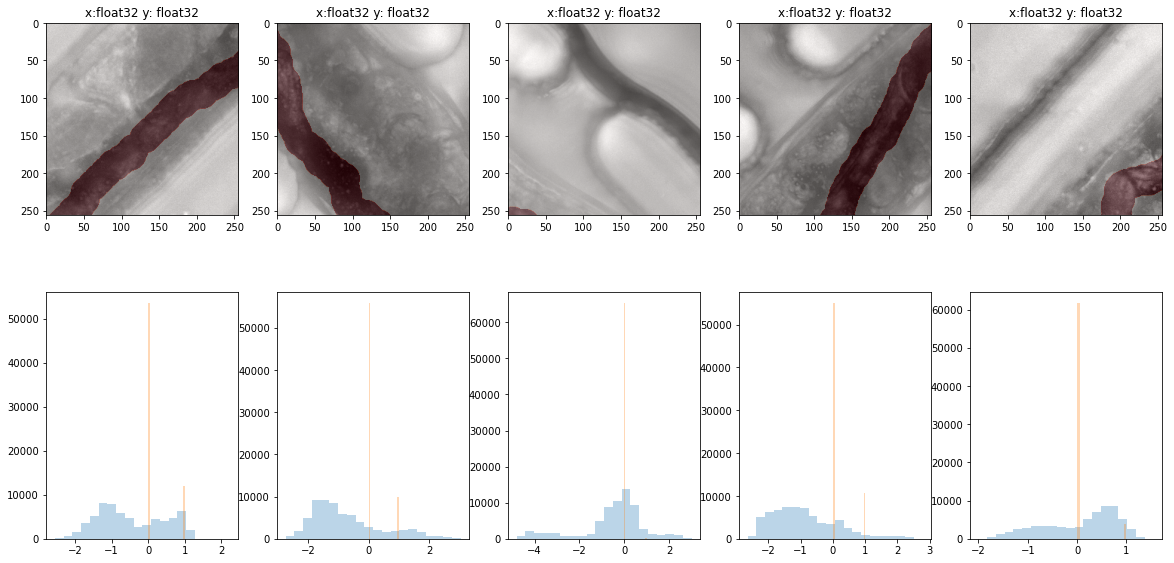

In [12]:
x = image_generator.next()
y = mask_generator.next()

print('x batch:', x.shape)
print('y batch:', y.shape)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,32)
    axs[0,i].imshow(x[ri,...,0], cmap='gray')
    axs[0,i].imshow(y[ri,...,0], cmap='Reds', alpha=0.3)
    axs[0,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
#     axs[1,i].imshow(x[ri+1,...,0], cmap='gray')
#     axs[1,i].imshow(y[i+1,...,0], cmap='Reds', alpha=0.3)
#     axs[1,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
    axs[1,i].hist(x[ri,...,0].flatten(), bins = 20,alpha = 0.3)
    axs[1,i].hist(y[ri,...,0].flatten(), bins = 20,alpha = 0.3)

plt.show()

In [13]:
x.shape

(32, 256, 256, 2)

In [18]:
N = x.shape[-1]

# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet',encoder_freeze=False)
inp = Input(shape =(None,None, N))
l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

# checkpoint path
checkpoint_path = 'bfg_to_gut_backresnet18_exp1_v1.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True,mode='min')

# logdirectory
log_fname = 'bfg_to_gut_backresnet18_exp1_v1.csv'
csvlogger = CSVLogger(filename=log_fname, separator=",", append=True)

In [19]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     9         
_________________________________________________________________
model_6 (Model)              (None, None, None, 1)     14340570  
Total params: 14,340,579
Trainable params: 14,330,653
Non-trainable params: 9,926
_________________________________________________________________


In [20]:
model.load_weights('bfg_to_gut_backresnet18_v1.h5')

In [21]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=10,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/10
32/32 [==============================] - 24s 765ms/step - loss: 0.7751 - iou_score: 0.4467 - val_loss: 1.5914 - val_iou_score: 0.2155
Epoch 2/10
32/32 [==============================] - 20s 625ms/step - loss: 0.6240 - iou_score: 0.5330 - val_loss: 1.2427 - val_iou_score: 0.2956
Epoch 3/10
32/32 [==============================] - 20s 612ms/step - loss: 0.5928 - iou_score: 0.5605 - val_loss: 0.8002 - val_iou_score: 0.5010
Epoch 4/10
32/32 [==============================] - 19s 592ms/step - loss: 0.5608 - iou_score: 0.5816 - val_loss: 0.7880 - val_iou_score: 0.4711
Epoch 5/10
32/32 [==============================] - 19s 595ms/step - loss: 0.5261 - iou_score: 0.6087 - val_loss: 0.6744 - val_iou_score: 0.5335
Epoch 6/10
32/32 [==============================] - 19s 604ms/step - loss: 0.4947 - iou_score: 0.6372 - val_loss: 0.5496 - val_iou_score: 0.6043
Epoch 7/10
32/32 [==============================] - 20s 611ms/step - loss: 0.4216 - iou_score: 0.6833 - val_loss: 0.5327 - val_iou

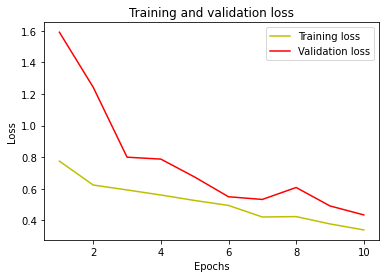

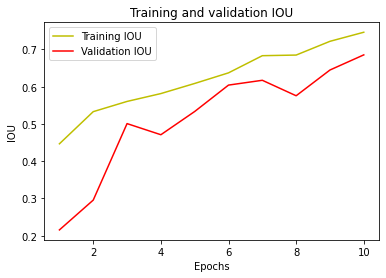

IoU socre is:  0.7261066613787177


In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


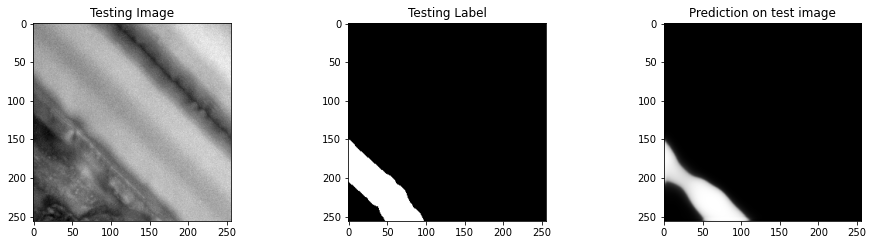

In [26]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [27]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=20,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/20
32/32 [==============================] - 19s 603ms/step - loss: 0.3101 - iou_score: 0.7648 - val_loss: 0.4145 - val_iou_score: 0.7067
Epoch 2/20
32/32 [==============================] - 18s 573ms/step - loss: 0.3285 - iou_score: 0.7613 - val_loss: 0.5641 - val_iou_score: 0.5986
Epoch 3/20
32/32 [==============================] - 18s 576ms/step - loss: 0.3040 - iou_score: 0.7771 - val_loss: 0.4630 - val_iou_score: 0.6653
Epoch 4/20
32/32 [==============================] - 19s 585ms/step - loss: 0.3182 - iou_score: 0.7713 - val_loss: 0.4170 - val_iou_score: 0.6956
Epoch 5/20
32/32 [==============================] - 18s 577ms/step - loss: 0.3197 - iou_score: 0.7699 - val_loss: 0.4836 - val_iou_score: 0.6628
Epoch 6/20
32/32 [==============================] - 19s 581ms/step - loss: 0.3043 - iou_score: 0.7781 - val_loss: 0.4495 - val_iou_score: 0.6736
Epoch 7/20
32/32 [==============================] - 19s 608ms/step - loss: 0.2693 - iou_score: 0.7983 - val_loss: 0.3795 - val_iou

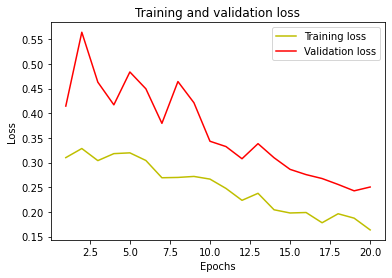

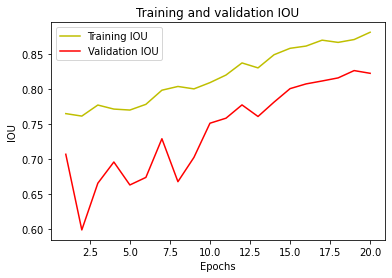

IoU socre is:  0.8596020200303994


In [28]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


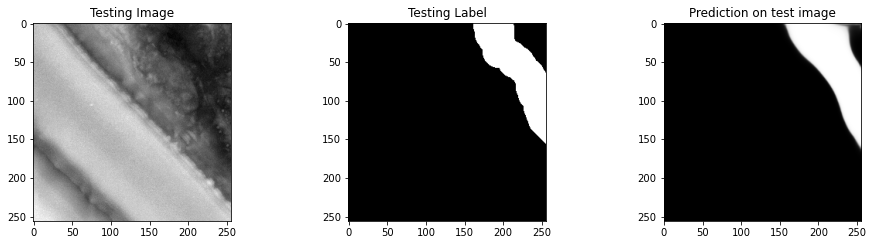

In [29]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [30]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=10,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/10
32/32 [==============================] - 18s 578ms/step - loss: 0.1247 - iou_score: 0.9031 - val_loss: 0.2590 - val_iou_score: 0.8247
Epoch 2/10
32/32 [==============================] - 19s 578ms/step - loss: 0.1602 - iou_score: 0.8878 - val_loss: 0.2466 - val_iou_score: 0.8302
Epoch 3/10
32/32 [==============================] - 20s 624ms/step - loss: 0.1751 - iou_score: 0.8832 - val_loss: 0.2343 - val_iou_score: 0.8351
Epoch 4/10
32/32 [==============================] - 20s 611ms/step - loss: 0.1707 - iou_score: 0.8847 - val_loss: 0.2280 - val_iou_score: 0.8402
Epoch 5/10
32/32 [==============================] - 19s 607ms/step - loss: 0.1548 - iou_score: 0.8927 - val_loss: 0.2353 - val_iou_score: 0.8386
Epoch 6/10
32/32 [==============================] - 20s 621ms/step - loss: 0.1466 - iou_score: 0.8943 - val_loss: 0.2281 - val_iou_score: 0.8452
Epoch 7/10
32/32 [==============================] - 19s 609ms/step - loss: 0.1367 - iou_score: 0.9001 - val_loss: 0.2310 - val_iou

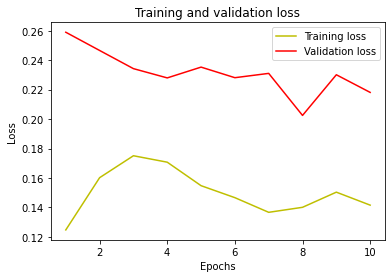

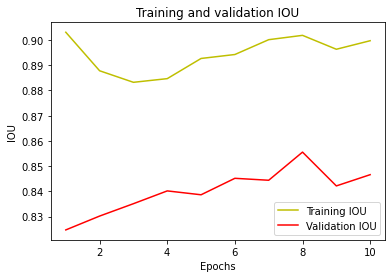

IoU socre is:  0.8697959153450384


In [31]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


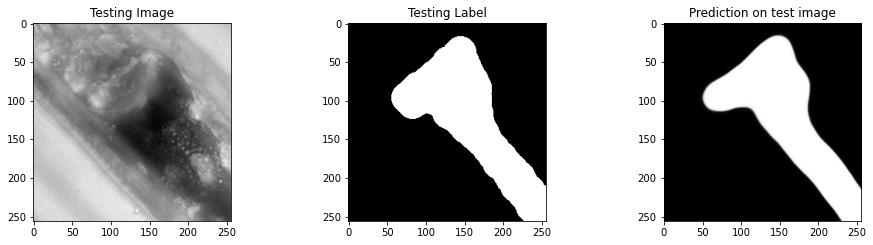

In [32]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()